In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import torch.nn.functional as F

# Set device to GPU or CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define a smaller batch size to reduce memory usage
batch_size = 64  # You can reduce it further if needed

# Define the data transformations for training and testing
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust the size to fit your model's input size
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust the size to fit your model's input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset with reduced batch size
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:05<00:00, 33286658.01it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


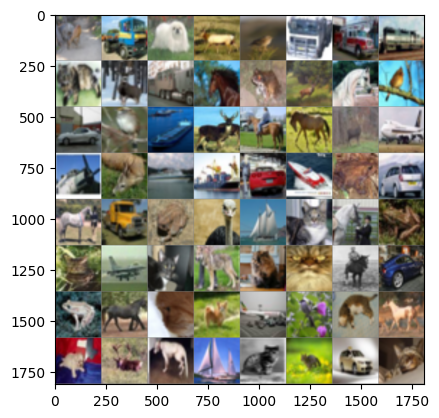

deer  truck dog   deer  bird  truck truck truck cat   deer  truck horse frog  deer  horse bird  car   bird  ship  deer  horse horse deer  plane plane deer  ship  ship  car   ship  frog  car   horse truck frog  bird  ship  cat   horse frog  cat   plane cat   dog   cat   cat   horse car   frog  horse cat   dog   plane bird  cat   horse dog   deer  dog   ship  cat   cat   car   cat  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

In [ ]:
from torchvision import models

# # Define Inception-ResNet-v2 with ResNet101 backbone
# class InceptionResNetV2(nn.Module):
#     def __init__(self, num_classes=10):
#         super(InceptionResNetV2, self).__init__()
#         # Load the ResNet101 model
#         self.backbone = models.resnet50()
#         # Modify or add additional layers according to your needs
#         self.fc = nn.Linear(1000, num_classes)  # Adjust input channels according to ResNet101 output

#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.fc(x)
#         return x

inception_model = models.inception_v3(pretrained=True)

In [ ]:
# Initialize the model
model = inception_model

# Move the model to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Check for the model's parameters
print(model.parameters())

<generator object Module.parameters at 0x794cb382a180>


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.RMSprop(net.parameters(), lr=0.001, alpha=0.9, weight_decay=0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

In [ ]:
model_name = "InceptionResNet_50_scartch_torchvision_10epoch"
# Training loop
num_epochs = 10
train_loss_list = []
valid_loss_list = []
train_accuracy_list = []
valid_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_accuracy = correct / total

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = running_loss / len(testloader)
    valid_accuracy = correct / total

    # Store loss and accuracy values
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_accuracy_list.append(train_accuracy)
    valid_accuracy_list.append(valid_accuracy)

    # Print the training/validation statistics
    print(f"Epoch: {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
          f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_accuracy:.4f}")

    # Update the learning rate
    # scheduler.step()
    scheduler1.step()
    scheduler2.step()

# Save the trained model
torch.save(model.state_dict(), model_name+".pth")

Epoch: 1/10 | Train Loss: 1.8364 | Train Acc: 0.3229 | Valid Loss: 1.5643 | Valid Acc: 0.4288
Epoch: 2/10 | Train Loss: 1.2687 | Train Acc: 0.5327 | Valid Loss: 1.1649 | Valid Acc: 0.5714
Epoch: 3/10 | Train Loss: 1.0097 | Train Acc: 0.6333 | Valid Loss: 1.1640 | Valid Acc: 0.5874
Epoch: 4/10 | Train Loss: 0.8573 | Train Acc: 0.6929 | Valid Loss: 0.8151 | Valid Acc: 0.7135
Epoch: 5/10 | Train Loss: 0.7393 | Train Acc: 0.7402 | Valid Loss: 0.7385 | Valid Acc: 0.7383
Epoch: 6/10 | Train Loss: 0.6417 | Train Acc: 0.7775 | Valid Loss: 0.6758 | Valid Acc: 0.7657
Epoch: 7/10 | Train Loss: 0.5666 | Train Acc: 0.8021 | Valid Loss: 0.6044 | Valid Acc: 0.7897
Epoch: 8/10 | Train Loss: 0.4988 | Train Acc: 0.8266 | Valid Loss: 0.5457 | Valid Acc: 0.8128
Epoch: 9/10 | Train Loss: 0.4496 | Train Acc: 0.8440 | Valid Loss: 0.5657 | Valid Acc: 0.8098
Epoch: 10/10 | Train Loss: 0.4027 | Train Acc: 0.8593 | Valid Loss: 0.5035 | Valid Acc: 0.8248


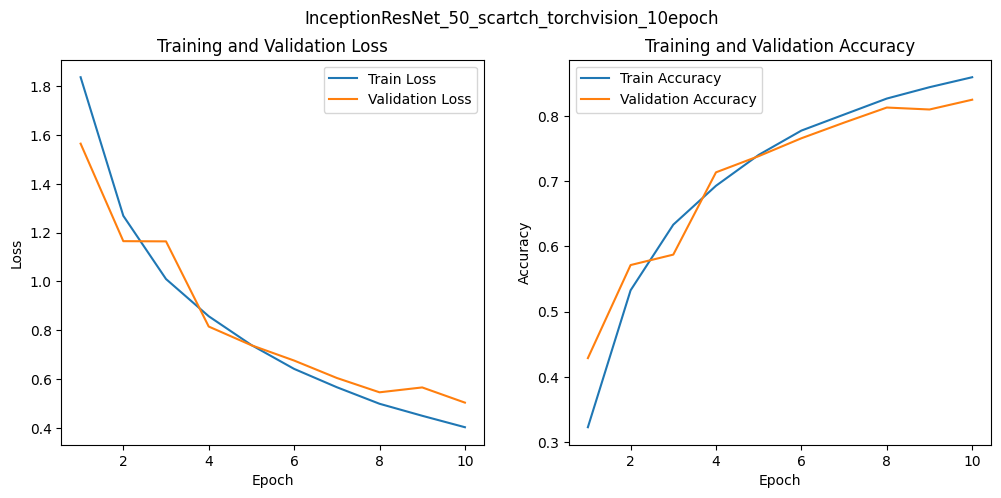

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Plot training and validation loss
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
# Plot training and validation accuracy
plt.plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), valid_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.suptitle(model_name)
plt.show()

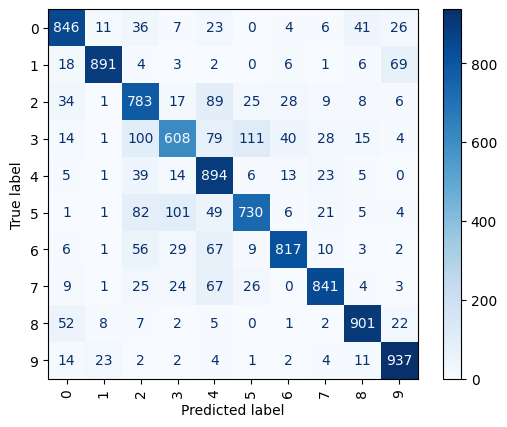

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

loaded_model = InceptionResNetV2()
loaded_model.load_state_dict(torch.load('/content/InceptionResNet_50_scartch_torchvision_10epoch.pth'))
loaded_model.to(device)  # Move the loaded model to the same device as the data

# Test the loaded model
def test_loaded_model(model, test_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Test the loaded model
all_preds, all_labels = test_loaded_model(loaded_model, testloader, device)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix using ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(all_labels))
cmd.plot(cmap='Blues', xticks_rotation='vertical')

# Show the plot
plt.show()